## Import des modules

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler,MultiLabelBinarizer

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

bc = pd.read_csv('seatle_after_analyze.csv')

# Discrétisation de la valeur Année
- Création de la colonne "YearBuiltDecade" afin de regrouper les données par décade

In [196]:
# Creation d'une nouvelle colonne suivant la valeur de YearBuilt
bc['YearBuiltDecade'] = pd.cut(bc['YearBuilt'], bins=range(1900, 2030, 10), right=False)

# Encodage des données en binaire
- Un batiment consomme de l'électricité ET du gaz : Colonne "HasGas" = 1
- Un batiment possède un parking : Colonne "HasParking" = 1

In [197]:
# Creation d'une nouvelle colonne suivant la valeur de PropertyGFAParking
bc['HasParking'] = bc['PropertyGFAParking'].apply(lambda x: 1 if x > 0 else 0)

# Creation d'une nouvelle colonne suivant la valeur de NaturalGas(kBtu)
bc['HasGas'] = bc['NaturalGas(kBtu)'].apply(lambda x: 1 if x > 0 else 0)

# Encodage des Types de Batiments
- PrimaryPropertyType
- Méthode pour numériser des catégories non ordonnées >>> LabelEncoder
- Méthode pour numériser des catégories non ordonnées >>> one hot encoding

In [198]:
Column_To_Encode = 'PrimaryPropertyType'
Label_Encode = 'LabelEncoder' + Column_To_Encode

LabelEncoder = LabelEncoder()
bc[Label_Encode] = LabelEncoder.fit_transform(bc[Column_To_Encode])
#print(bc[[Column_To_Label_Encode, 'LabelEncoderColumn']].head())
unique_pairs = bc[[Column_To_Encode, Label_Encode]].drop_duplicates().sort_values(Label_Encode)
print(unique_pairs)

              PrimaryPropertyType  LabelEncoderPrimaryPropertyType
93            Distribution Center                                0
1095                     Hospital                                1
0                           Hotel                                2
5                     K-12 School                                3
180                    Laboratory                                4
20                   Large Office                                5
392          Low-Rise Multifamily                                6
191                Medical Office                                7
4              Mixed Use Property                                8
1333                       Office                                9
3                           Other                               10
259        Refrigerated Warehouse                               11
66                 Residence Hall                               12
412                    Restaurant                             

# Encodage de la Localisation des Batiments
- Neighborhood
- Méthode pour numériser des catégories non ordonnées >>> one hot encoding

In [199]:
Column_To_Encode = 'Neighborhood'
Label_Encode = 'LabelEncoder' + Column_To_Encode

bc[Label_Encode] = LabelEncoder.fit_transform(bc[Column_To_Encode])
#print(bc[[Column_To_Label_Encode, 'LabelEncoderColumn']].head())
unique_pairs = bc[[Column_To_Encode, Label_Encode]].drop_duplicates().sort_values(Label_Encode)
print(unique_pairs)

             Neighborhood  LabelEncoderNeighborhood
16                BALLARD                         0
31                CENTRAL                         1
76               DELRIDGE                         2
0                DOWNTOWN                         3
8                    EAST                         4
17       GREATER DUWAMISH                         5
11             LAKE UNION                         6
14  MAGNOLIA / QUEEN ANNE                         7
10                  NORTH                         8
6               NORTHEAST                         9
18              NORTHWEST                        10
5               SOUTHEAST                        11
83              SOUTHWEST                        12


# Encodage des Usages des Batiments

Nombre de valeurs regroupées en RARE : 32

Résultat MultiLabelBinarizer :

Colonnes créées: ['Bank Branch', 'College/University', 'Data Center', 'Distribution Center', 'Fitness Center/Health Club/Gym', 'Food Service', 'Hotel', 'K-12 School', 'Manufacturing/Industrial Plant', 'Medical Office', 'Multifamily Housing', 'Non-Refrigerated Warehouse', 'Office', 'Other', 'Other - Entertainment/Public Assembly', 'Other - Recreation', 'Other - Services', 'Parking', 'Pre-school/Daycare', 'Rare', 'Refrigerated Warehouse', 'Residence Hall/Dormitory', 'Restaurant', 'Retail Store', 'Self-Storage Facility', 'Senior Care Community', 'Social/Meeting Hall', 'Supermarket/Grocery Store', 'Swimming Pool', 'Worship Facility']


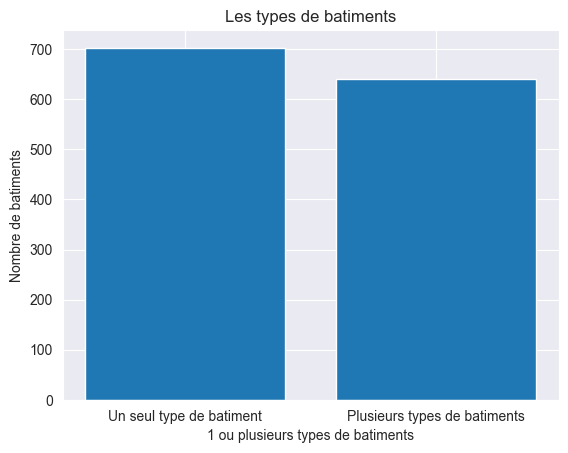

In [200]:
# Supprimer tout ce qui est entre parenthèses (y compris les parenthèses elles-mêmes)
bc["ListOfAllPropertyUseTypes"] = bc["ListOfAllPropertyUseTypes"].str.replace(r"\([^)]*\)", "", regex=True)

all_values = []
for row in bc['ListOfAllPropertyUseTypes']:
    values = [v.strip() for v in str(row).split(',')]
    all_values.extend(values)

# Compter et trier par fréquence (décroissant)

value_counts = Counter(all_values)
sorted_values = value_counts.most_common()

#print("Valeurs triées par fréquence :")
#for value, count in sorted_values:
#    print(f"{value}: {count}")

    # Identifier les valeurs avec moins de 10 occurrences
rare_values = [value for value, count in value_counts.items() if count < 10]

# Créer une nouvelle colonne avec regroupement "Divers"
def categorize_property_types(row):
    if pd.isna(row):
        return row
    values = [v.strip() for v in str(row).split(',')]
    new_values = []
    for value in values:
        if value in rare_values:
            new_values.append('Rare')
        else:
            new_values.append(value)
    return ', '.join(new_values)

bc['ListOfAllPropertyUseTypes_Grouped'] = bc['ListOfAllPropertyUseTypes'].apply(categorize_property_types)

# Afficher les statistiques
print(f"Nombre de valeurs regroupées en RARE : {len(rare_values)}")

######################################################
######################################################

property_use_lists = []
for row in bc['ListOfAllPropertyUseTypes_Grouped']:
    values = [v.strip() for v in str(row).split(',')]
    property_use_lists.append(values)

mlb = MultiLabelBinarizer()
mlb_result = mlb.fit_transform(property_use_lists)
# Ajouter le préfixe "p_"
col_names = ["p_" + c for c in mlb.classes_]

mlb_df = pd.DataFrame(mlb_result, columns=col_names, index=bc.index)

bc = pd.concat([bc, mlb_df], axis=1)

print(f"\nRésultat MultiLabelBinarizer :")
print(f"\nColonnes créées: {list(mlb.classes_)}")

######################################################
######################################################

# ✅ Compter le nombre de 1 par ligne dans les colonnes "p_..."
bc["count_ones"] = bc[bc.columns[bc.columns.str.startswith("p_")]].sum(axis=1)

# ✅ Vérifier si supérieur à 1
bc["properties"] = bc["count_ones"] > 1

# Remplacer True/False par du texte plus parlant
bc["properties_label"] = bc["properties"].map({
    True: "Plusieurs types de batiments",
    False: "Un seul type de batiment"
})

counts = bc["properties_label"].value_counts()

# Création du graphique
plt.bar(counts.index.astype(str), counts.values)

plt.xlabel("1 ou plusieurs types de batiments")
plt.ylabel("Nombre de batiments")
plt.title("Les types de batiments")
plt.show()

# DERNIER NETTOYAGE DE COLONNE

In [ ]:
# Suppression des colonnes
bc.drop((['PrimaryPropertyType', 'ZipCode', 'Neighborhood', 'YearBuilt', 'ListOfAllPropertyUseTypes', 'ListOfAllPropertyUseTypes_Grouped']), axis=1, inplace=True)


# EXPORT CSV

In [201]:
print(f"Nombre de batiments non residentiels Traités: {len(bc)}")

# Générer la date/heure au format AAMMJJHHMMSS
timestamp = datetime.now().strftime("%y%m%d%H%M%S")
# Nom du fichier avec la date
#filename_export = f"seatle_{timestamp}.csv"
filename = f"seatle_after_feature_engineering.csv"
# Export CSV
#bc.to_csv(f'exports/{filename_export}', index=False)
bc.to_csv(f'{filename}', index=False)

Nombre de batiments non residentiels Traités: 1343
